# Testing Adaptive Learning with Simulations

### Import Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/qinfer/.*')
from __future__ import division # Ensures that a/b is always a float.

In [2]:
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m
from adaptive import *

reload(m)

<module 'models' from 'models.pyc'>

In [3]:
parallel=True
if parallel:
    from ipyparallel import Client
    rc = Client()
    dview = rc[:]
    dview.use_dill()
    
    with dview.sync_imports():
        import os

    # Change directory on engines so that we can import models.
    if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
        print "Changed engine directories to notebook directory."
        
    # To ensure that we don't enter into a Matplotlib event loop
    # on our engines, we set the MPLBACKEND to the non-interactive
    # Agg backend first. This is especially useful if the engines
    # are connected via SSH.
    if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
        print "Changed MPL backend."
        
    # Force each engine to import QInfer before proceeding.
    if dview.execute('import qinfer as qi').get():
        print "Successfully imported QInfer on engines."
        
    if dview.execute('import models').get():
        print "Successfully imported models."
    
    print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


### Setup

Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [4]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = False
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

### Initialize QInfer Objects

In [5]:
ham_model = m.RabiRamseyModel()
ham_model._Q = np.array([1,1,0,0,0])

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")
 - wo: Carrier offset from 2870MHz, positive or negative (MHz)

In [6]:
true_value = np.array([5.555, 1.432, 0.579, 2.171, 0.25])
target_stds = np.array([0.01,0.005,0.01,0.005,0.01])
wide_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1]
        ]))
narrow_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)
medium_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    10*target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)

###  Simulation Tests

(0, 1)

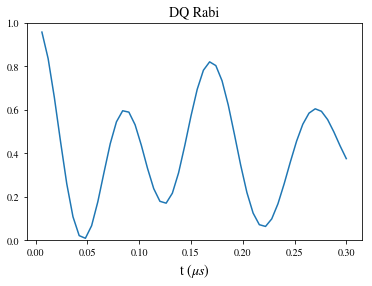

In [7]:
rabi_eps = rabi_sweep(max_t=0.3,n=50)
plt.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:])
plt.title('DQ Rabi')
plt.xlabel('t $(\mu s)$')
plt.ylim(0,1)

(0, 1)

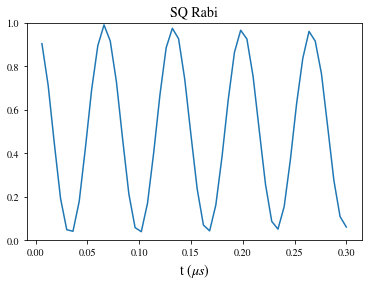

In [8]:
rabi_eps = rabi_sweep(max_t=0.3,n=50,wo=50)
params = true_value[np.newaxis,:]+np.array([5,-50,0,0,0])
plt.plot(rabi_eps['t'], ham_model.likelihood(0, params, rabi_eps)[0,0,:])
plt.title('SQ Rabi')
plt.xlabel('t $(\mu s)$')
plt.ylim([0,1])

(0, 1)

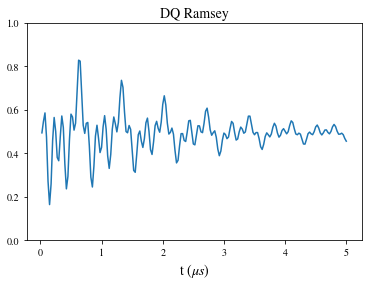

In [9]:
tp_est = 1 / true_value[0] / 4

ramsey_eps = ramsey_sweep(max_tau=5,n=200,tp=tp_est,phi=np.pi)
plt.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:])

plt.title('DQ Ramsey')
plt.xlabel('t $(\mu s)$')
plt.ylim([0,1])

### Speed Tests

In [11]:
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(10000), rabi_sweep(max_t=0.3,n=50))
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(10000), ramsey_sweep(max_tau=2,n=50))
if parallel:
    %timeit -n1 -r1 qi.DirectViewParallelizedModel(ham_model,dview).likelihood(1, wide_prior.sample(10000), rabi_sweep(max_t=0.3,n=50))
    %timeit -n1 -r1 qi.DirectViewParallelizedModel(ham_model,dview).likelihood(1, wide_prior.sample(10000), ramsey_sweep(max_tau=2,n=50))

1 loop, best of 1: 12 s per loop
1 loop, best of 1: 23 s per loop
1 loop, best of 1: 1.48 s per loop
1 loop, best of 1: 2.75 s per loop


In [12]:
updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(ramsey_eps)
%timeit -n1 -r1 updater.expected_information_gain(rabi_eps)
%timeit -n1 -r1 updater.expected_information_gain(ramsey_eps)
if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
    %timeit -n1 -r1 updater.bayes_risk(rabi_eps)
    %timeit -n1 -r1 updater.bayes_risk(ramsey_eps)
    %timeit -n1 -r1 updater.expected_information_gain(rabi_eps)
    %timeit -n1 -r1 updater.expected_information_gain(ramsey_eps)

1 loop, best of 1: 5.5 s per loop
1 loop, best of 1: 10.3 s per loop
1 loop, best of 1: 5.51 s per loop
1 loop, best of 1: 10.2 s per loop
1 loop, best of 1: 847 ms per loop
1 loop, best of 1: 1.47 s per loop
1 loop, best of 1: 772 ms per loop
1 loop, best of 1: 1.3 s per loop


###  Test Risk and Information Gain

Skipping ../fig/risk-and-ig-tight-prior.png
Skipping ../fig/risk-and-ig-tight-prior.pdf


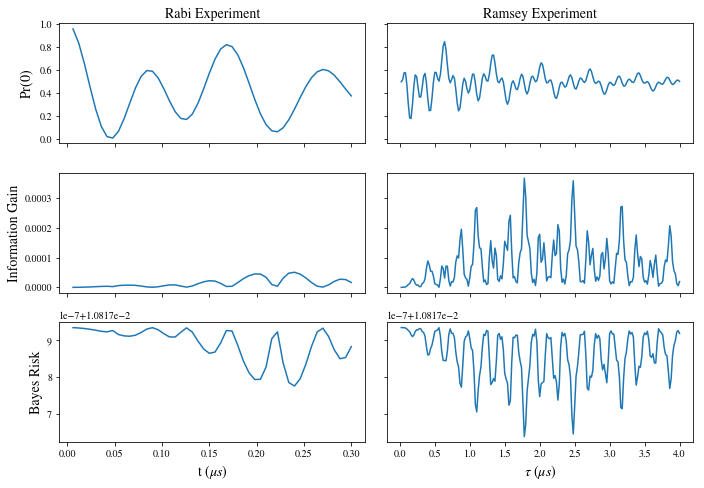

In [12]:
if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
else:
    updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
ham_model._Q = np.array([1,1,1,1,1])

fig = plt.figure(figsize=(10,7))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_ig = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_risk = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_ig.plot(rabi_eps['t'], updater.expected_information_gain(rabi_eps), label='Rabi EIG')
ax_rabi_risk.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps)), label='Rabi Bayes Risk')

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_ig = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_ig)
ax_ramsey_risk = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_risk)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=4,n=200,tp=tp_est)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_ig.plot(ramsey_eps['tau'], updater.expected_information_gain(ramsey_eps), label='Ramsey EIG')
ax_ramsey_risk.plot(ramsey_eps['tau'], np.sqrt(updater.bayes_risk(ramsey_eps)), label='Ramsey Bayes Risk')

plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_ig.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
ax_rabi_risk.set_xlabel(r't $(\mu s)$')
ax_ramsey_risk.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_ig.set_ylabel('Information Gain')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_risk.set_ylabel('Bayes Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()

export_figure(fig, 'risk-and-ig-tight-prior')

Overwriting ../fig/risk-and-ig-compare-strategies.png
Overwriting ../fig/risk-and-ig-compare-strategies.pdf


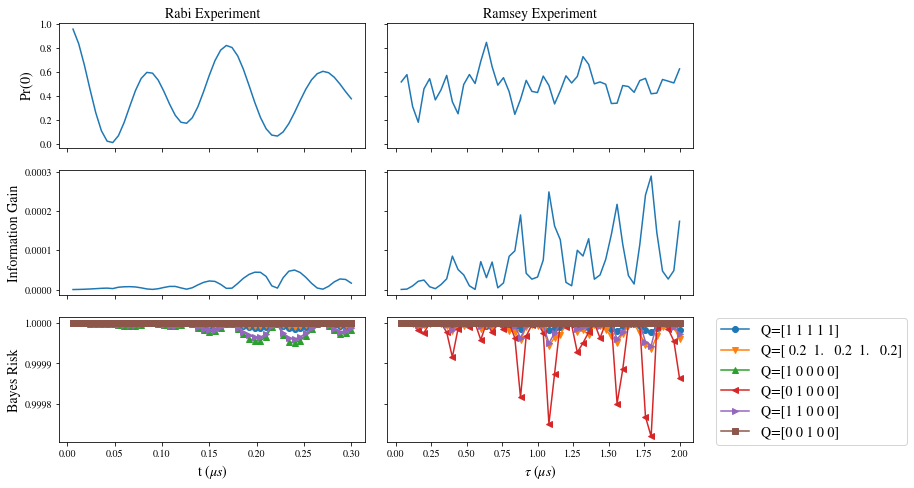

In [14]:
def weighted_variance(updater):
    xs = updater.particle_locations-updater.est_mean()
    xs = np.sum(updater.model.Q * xs**2, axis=1)
    return np.sum(updater.particle_weights * xs)

if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
else:
    updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
Qs = [
    np.array([1,1,1,1,1]),
    np.array([0.2,1,0.2,1,0.2]),
    np.array([1,0,0,0,0]),
    np.array([0,1,0,0,0]),
    np.array([1,1,0,0,0]),
    np.array([0,0,1,0,0]),
]

fig = plt.figure(figsize=(10,7))
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_ig = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_risk = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_ig.plot(rabi_eps['t'], updater.expected_information_gain(rabi_eps), label='Rabi EIG')

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_ig = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_ig)
ax_ramsey_risk = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_risk)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=2,n=50,tp=tp_est)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_ig.plot(ramsey_eps['tau'], updater.expected_information_gain(ramsey_eps), label='Ramsey EIG')

for idx_Q, Q in enumerate(Qs):
    marker = markers.next()
    ham_model._Q = Q
    
    ax_rabi_risk.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps) / weighted_variance(updater)), marker=marker, label='Q={}'.format(Q))
    ax_ramsey_risk.plot(ramsey_eps['tau'], np.sqrt(updater.bayes_risk(ramsey_eps) / weighted_variance(updater)), marker=marker, label='Q={}'.format(Q))


plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_ig.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
ax_rabi_risk.set_xlabel(r't $(\mu s)$')
ax_ramsey_risk.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_ig.set_ylabel('Information Gain')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_risk.set_ylabel('Bayes Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()
plt.sca(ax_ramsey_risk)
plt.legend(bbox_to_anchor=(1.05, 1.05))

export_figure(fig, 'risk-and-ig-compare-strategies')

Overwriting ../fig/risk-bern-vs-bin.png
Overwriting ../fig/risk-bern-vs-bin.pdf


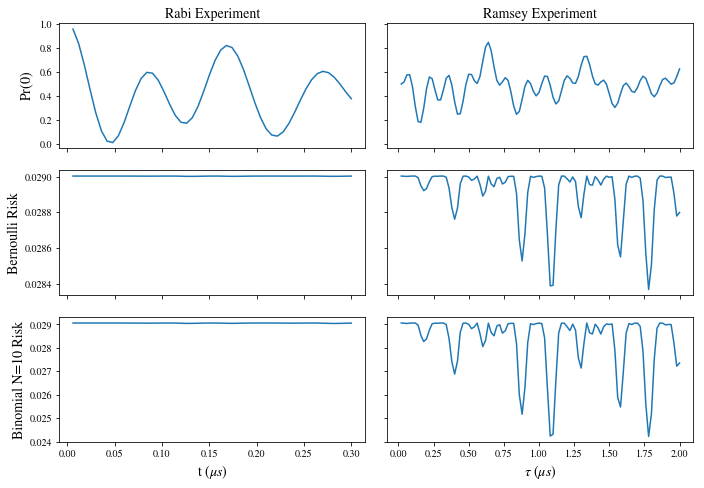

In [15]:
bern_model = m.RabiRamseyModel()
bin_model = qi.BinomialModel(bern_model)
updater_bern = qi.SMCUpdater(bern_model, 5000, medium_prior)
updater_bin = qi.SMCUpdater(bin_model, 5000, medium_prior)
bern_model._Q = np.array([0,1,0,0,0])
bin_model._Q = np.array([0,1,0,0,0])

fig = plt.figure(figsize=(10,7))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_bern = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_bin = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50,n_bin=10)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_bern.plot(rabi_eps['t'], np.sqrt(updater_bern.bayes_risk(rabi_eps)))
ax_rabi_bin.plot(rabi_eps['t'], np.sqrt(updater_bin.bayes_risk(rabi_eps)))

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_bern = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_bern)
ax_ramsey_bin = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_bin)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=tp_est,n_bin=10)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_bern.plot(ramsey_eps['tau'], np.sqrt(updater_bern.bayes_risk(ramsey_eps)))
ax_ramsey_bin.plot(ramsey_eps['tau'], np.sqrt(updater_bin.bayes_risk(ramsey_eps)))

plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_bern.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_bern.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_bern.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_bin.get_yticklabels(), visible=False)
ax_rabi_bin.set_xlabel(r't $(\mu s)$')
ax_ramsey_bin.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_bern.set_ylabel('Bernoulli Risk')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_bin.set_ylabel('Binomial N=10 Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()

export_figure(fig, 'risk-bern-vs-bin')

### Adaptive Simulations

In [7]:
n_bin = 10
n_particles = 2000
n_experiments = 100
n_trials = 1

def make_updater():
    if not parallel:
        return qi.BinomialModel(m.RabiRamseyModel())
    else:
        return qi.DirectViewParallelizedModel(qi.BinomialModel(m.RabiRamseyModel()), dview, serial_threshold=1)

Qs = [
    np.array([1,1,1,1,1]),
    np.array([1,0,0,0,0]),
    np.array([0,1,0,0,0]),
    np.array([1,1,0,0,0]),
    np.array([0,0,1,0,0])
]
n_updaters = len(Qs) + 3

heuristics = []

track_means = np.zeros((n_trials, n_updaters, n_experiments + 1, 5))
track_covs = np.zeros((n_trials, n_updaters, n_experiments + 1, 5, 5))

for idx_trial in range(n_trials):
    heuristics.append([])
    heuristics[-1] = [
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            dview=dview
        )
        for Q in Qs
    ]

    heuristics[-1] += [InfoGainHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
        rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
        ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
        dview=dview
    )]
    heuristics[-1] += [ExponentialHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior),
        max_t=0.5, max_tau=2, base=11/10, n=50, n_bin=n_bin
    )]
    heuristics[-1] += [LinearHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior),
        max_t=0.5, max_tau=2, n=50, n_bin=n_bin
    )]

    n_updaters = len(heuristics[-1])

    for idx_h, h in enumerate(heuristics[-1]):
        track_means[idx_trial,idx_h, 0, :] = h.updater.est_mean()
        track_covs[idx_trial,idx_h, 0, :, :] = h.updater.est_covariance_mtx()

    for idx_eps in range(n_experiments):

        for idx in range(n_updaters):
            heuristic = heuristics[-1][idx]
            updater = heuristic.updater

            #estimate ramsey pulse time
            current_est = updater.est_mean()
            tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002

            #decide experiment
            eps = heuristic(tp_est)
            print("{}: {} : {}".format(idx_eps, heuristic.name, eps[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))

            # simulate outcome
            outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps)

            # update
            updater.update(outcome, eps)

            # store info
            track_means[idx_trial,idx, idx_eps + 1, :] = updater.est_mean()
            track_covs[idx_trial,idx, idx_eps + 1, :, :] = updater.est_covariance_mtx()
        print "---"

0: Bayes Risk, Q=[1 1 1 1 1] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2890.  2845.  2872.   581.   287.]
0: Bayes Risk, Q=[1 0 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2914.  2884.  2861.   560.   285.]
0: Bayes Risk, Q=[0 1 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2905.  2899.  2945.   575.   285.]
0: Bayes Risk, Q=[1 1 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2920.  2887.  2915.   573.   285.]
0: Bayes Risk, Q=[0 0 1 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2921.  2904.  2864.   579.   284.]
0: Expected Information Gain : ( 0.03,  0.,  0.,  0., 0, 10) [ 2913.  2833.  2832.   569.   287.]
0: Exponentially Sparse Heur : ( 0.004,  0.,  0.,  0., 0, 10) [ 2873.  2880.  2894.   570.   285.]
0: Standard Linear Heuristic : ( 0.02,  0.,  0.,  0., 0, 10) [ 2860.  2855.  2909.   575.   286.]
---
1: Bayes Risk, Q=[1 1 1 1 1] : ( 0.1,  0.,  0.,  0., 0, 10) [ 1174.  2794.  3023.   594.   280.]
1: Bayes Risk, Q=[1 0 0 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [ 1374.  2868.  2998.   567.   282.]
1: Bayes Risk, Q

10: Bayes Risk, Q=[1 1 0 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  273.   638.  1821.   420.   281.]
10: Bayes Risk, Q=[0 0 1 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [  246.   641.  1766.   449.   306.]
10: Expected Information Gain : ( 0.048,  0.12,  0.,  0., 1, 10) [  239.  1580.  2517.   397.   250.]
10: Exponentially Sparse Heur : ( 0.008,  0.,  0.,  0., 0, 10) [ 1619.  2588.  2918.   542.   276.]
10: Standard Linear Heuristic : ( 0.12,  0.,  0.,  0., 0, 10) [  662.  2318.  2421.   533.   260.]
---
11: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.16,  0.,  0., 1, 10) [  332.   992.  2598.   505.   259.]
11: Bayes Risk, Q=[1 0 0 0 0] : ( 0.48,  0.,  0.,  0., 0, 10) [  235.   619.  1425.   308.   253.]
11: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  0.16,  0.,  0., 1, 10) [  456.  1192.  1394.   465.   251.]
11: Bayes Risk, Q=[1 1 0 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [  259.   733.  1795.   480.   280.]
11: Bayes Risk, Q=[0 0 1 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [  232.   519.  1752.   459.   30

20: Expected Information Gain : ( 0.046,  0.2,  0.,  0., 1, 10) [  136.   783.  2058.   262.   259.]
20: Exponentially Sparse Heur : ( 0.012,  0.,  0.,  0., 0, 10) [ 1028.  2009.  2842.   516.   267.]
20: Standard Linear Heuristic : ( 0.22,  0.,  0.,  0., 0, 10) [  141.   224.  1755.   217.   206.]
---
21: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.56,  0.,  0., 1, 10) [  114.   198.  1931.   214.   225.]
21: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.36,  0.,  0., 1, 10) [   84.   143.  1409.   158.   249.]
21: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.24,  0.,  0., 1, 10) [  115.   495.  1166.   392.   228.]
21: Bayes Risk, Q=[1 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   81.   193.  1055.   192.   269.]
21: Bayes Risk, Q=[0 0 1 0 0] : ( 0.048,  0.08,  0.,  0., 1, 10) [  141.   389.  1665.   344.   291.]
21: Expected Information Gain : ( 0.046,  0.12,  0.,  0., 1, 10) [  145.   822.  2037.   238.   248.]
21: Exponentially Sparse Heur : ( 0.038,  0.048,  0.,  0., 1, 10) [  936.  2029.  2840.

30: Standard Linear Heuristic : ( 0.32,  0.,  0.,  0., 0, 10) [   96.   211.  1151.   215.   181.]
---
31: Bayes Risk, Q=[1 1 1 1 1] : ( 0.42,  0.,  0.,  0., 0, 10) [   72.   126.  1270.   141.   184.]
31: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.84,  0.,  0., 1, 10) [   68.   145.  1115.   166.   200.]
31: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [   69.   261.  1124.   266.   203.]
31: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  71.  198.  847.  196.  248.]
31: Bayes Risk, Q=[0 0 1 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  133.   413.  1590.   340.   277.]
31: Expected Information Gain : ( 0.046,  0.36,  0.,  0., 1, 10) [   91.   366.  1534.   206.   243.]
31: Exponentially Sparse Heur : ( 0.042,  0.078,  0.,  0., 1, 10) [  574.  2316.  2847.   548.   269.]
31: Standard Linear Heuristic : ( 0.044,  0.32,  0.,  0., 1, 10) [  100.   246.  1195.   251.   183.]
---
32: Bayes Risk, Q=[1 1 1 1 1] : ( 0.41,  0.,  0.,  0., 0, 10) [   78.   130.  1459.   1

41: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  1.08,  0.,  0., 1, 10) [  50.   73.  982.   82.  156.]
41: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.8,  0.,  0., 1, 10) [  42.   52.  736.   70.  151.]
41: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.84,  0.,  0., 1, 10) [  48.   25.  606.   39.  112.]
41: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [   77.   274.  1413.   252.   224.]
41: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [  102.   360.  1842.   215.   275.]
41: Exponentially Sparse Heur : ( 0.042,  0.126,  0.,  0., 1, 10) [  394.  2117.  2937.   481.   260.]
41: Standard Linear Heuristic : ( 0.044,  0.42,  0.,  0., 1, 10) [  56.  181.  767.  160.  220.]
---
42: Bayes Risk, Q=[1 1 1 1 1] : ( 0.05,  0.,  0.,  0., 0, 10) [   55.    56.  1197.   109.   141.]
42: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  1.16,  0.,  0., 1, 10) [   57.   121.  1137.   124.   194.]
42: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  40.   56.  724.   70.  156.]
42: Bay

51: Bayes Risk, Q=[0 0 1 0 0] : ( 0.41,  0.,  0.,  0., 0, 10) [   71.   242.  1253.   219.   208.]
51: Expected Information Gain : ( 0.046,  0.44,  0.,  0., 1, 10) [   85.   188.  1621.   189.   263.]
51: Exponentially Sparse Heur : ( 0.042,  0.204,  0.,  0., 1, 10) [  318.  1983.  2501.   378.   247.]
51: Standard Linear Heuristic : ( 0.044,  0.52,  0.,  0., 1, 10) [  48.   60.  779.   62.  196.]
---
52: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.68,  0.,  0., 1, 10) [   46.    38.  1163.    49.   122.]
52: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  50.   68.  986.   77.  181.]
52: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  1.56,  0.,  0., 1, 10) [  39.   18.  733.   27.   82.]
52: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  1.12,  0.,  0., 1, 10) [  44.   21.  567.   34.   92.]
52: Bayes Risk, Q=[0 0 1 0 0] : ( 0.41,  0.,  0.,  0., 0, 10) [   69.   229.  1208.   209.   205.]
52: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [   84.   203.  1606.   185.   260.]
52: 

61: Standard Linear Heuristic : ( 0.044,  0.62,  0.,  0., 1, 10) [  52.   45.  646.   49.  169.]
---
62: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.84,  0.,  0., 1, 10) [   36.    24.  1016.    28.    86.]
62: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [  43.   30.  872.   39.  114.]
62: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  37.   15.  801.   25.   63.]
62: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.52,  0.,  0., 1, 10) [  36.   17.  562.   29.   68.]
62: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [   65.   175.  1373.   184.   189.]
62: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [   70.    74.  1383.    97.   182.]
62: Exponentially Sparse Heur : ( 0.09,  0.,  0.,  0., 0, 10) [  305.  1840.  2216.   323.   230.]
62: Standard Linear Heuristic : ( 0.64,  0.,  0.,  0., 0, 10) [  52.   39.  621.   43.  155.]
---
63: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.56,  0.,  0., 1, 10) [   36.    24.  1001.    28.    86.]
63: Bayes

72: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.4,  0.,  0., 1, 10) [  35.   17.  561.   25.   73.]
72: Bayes Risk, Q=[0 0 1 0 0] : ( 0.41,  0.,  0.,  0., 0, 10) [   57.   117.  1017.   124.   173.]
72: Expected Information Gain : ( 0.046,  1.08,  0.,  0., 1, 10) [   60.    43.  1534.    61.   142.]
72: Exponentially Sparse Heur : ( 0.144,  0.,  0.,  0., 0, 10) [  132.   441.  1268.   193.   177.]
72: Standard Linear Heuristic : ( 0.74,  0.,  0.,  0., 0, 10) [  45.   27.  479.   33.  120.]
---
73: Bayes Risk, Q=[1 1 1 1 1] : ( 0.42,  0.,  0.,  0., 0, 10) [  26.   17.  744.   24.   75.]
73: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.68,  0.,  0., 1, 10) [  42.   28.  827.   29.   97.]
73: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  34.   15.  790.   25.   58.]
73: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.4,  0.,  0., 1, 10) [  35.   16.  566.   25.   72.]
73: Bayes Risk, Q=[0 0 1 0 0] : ( 0.4,  0.,  0.,  0., 0, 10) [   58.   119.  1023.   125.   173.]
73: Expected Information G

83: Bayes Risk, Q=[1 1 1 1 1] : ( 0.43,  0.,  0.,  0., 0, 10) [  27.   15.  841.   25.   76.]
83: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  1.16,  0.,  0., 1, 10) [  39.   21.  799.   24.   85.]
83: Bayes Risk, Q=[0 1 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  29.   15.  624.   25.   66.]
83: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.48,  0.,  0., 1, 10) [  34.   14.  602.   23.   64.]
83: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.84,  0.,  0., 1, 10) [   47.    38.  1071.    50.   164.]
83: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [   56.    37.  1385.    49.   138.]
83: Exponentially Sparse Heur : ( 0.046,  0.934,  0.,  0., 1, 10) [   93.   369.  1239.   155.   183.]
83: Standard Linear Heuristic : ( 0.046,  0.84,  0.,  0., 1, 10) [  42.   23.  427.   22.  101.]
---
84: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.12,  0.,  0., 1, 10) [  28.   15.  893.   26.   76.]
84: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.68,  0.,  0., 1, 10) [  39.   21.  790.   24.   86.]
84: Bayes Risk, Q=[

93: Bayes Risk, Q=[0 0 1 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   40.    22.  1389.    31.   107.]
93: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [   44.    44.  1202.    40.   117.]
93: Exponentially Sparse Heur : ( 0.046,  1.502,  0.,  0., 1, 10) [   82.   376.  1119.   165.   189.]
93: Standard Linear Heuristic : ( 0.046,  0.94,  0.,  0., 1, 10) [  33.   18.  388.   20.   80.]
---
94: Bayes Risk, Q=[1 1 1 1 1] : ( 0.43,  0.,  0.,  0., 0, 10) [  31.   12.  947.   21.   67.]
94: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.88,  0.,  0., 1, 10) [  40.   20.  804.   21.   83.]
94: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  1.84,  0.,  0., 1, 10) [  23.   14.  619.   18.   59.]
94: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  1.16,  0.,  0., 1, 10) [  31.   11.  568.   18.   51.]
94: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  1.52,  0.,  0., 1, 10) [   41.    22.  1490.    30.   112.]
94: Expected Information Gain : ( 0.046,  1.08,  0.,  0., 1, 10) [   45.    46.  1220.    40.   116.]
94: Expon

Overwriting ../fig/qhl-wr-variance.png
Overwriting ../fig/qhl-wr-variance.pdf


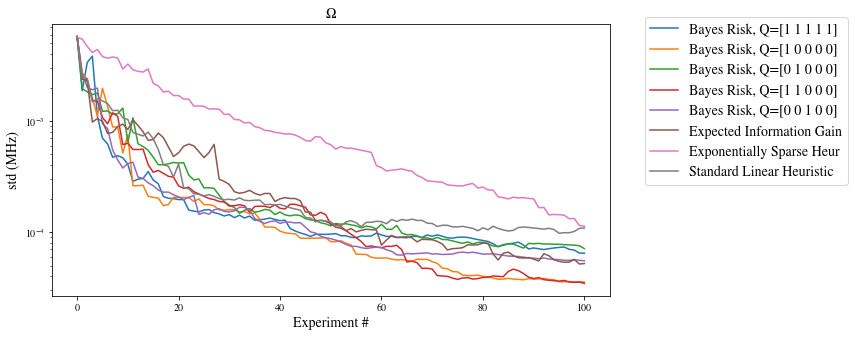

In [118]:
idx_model = 0
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:101,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-wr-variance')

Overwriting ../fig/qhl-we-variance.png
Overwriting ../fig/qhl-we-variance.pdf


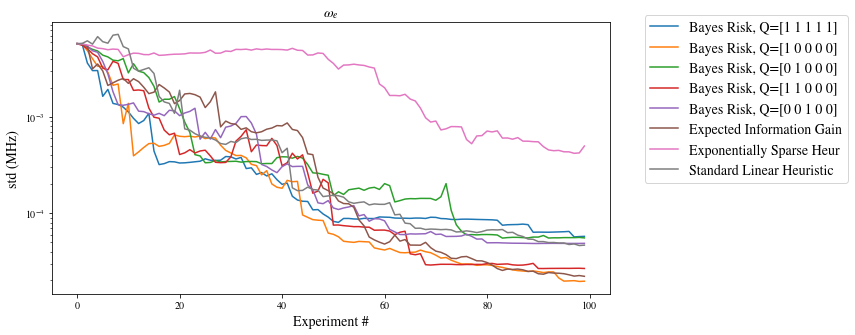

In [119]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:100,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-we-variance')

Overwriting ../fig/qhl-AN-variance.png
Overwriting ../fig/qhl-AN-variance.pdf


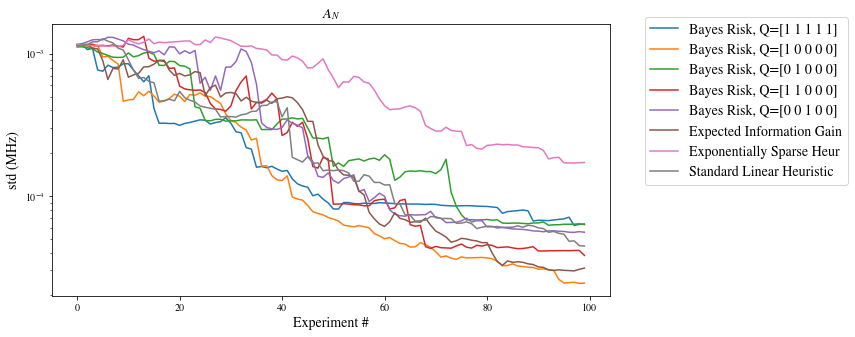

In [120]:
idx_model = 3
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:100,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-AN-variance')

### Lookahead Heuristic

It would be beneficial to do risk calculations at the same time as experiments, since both tasks are time consuming. The problem, however, is that calculating the best next experiment to do next relies on the latest data, which we would not have if we are doing experiments and calculations concurrently. Three ideas:
 - Scrap concurrency, and just alternate between experiments and next best experiment simulations
 - Choose the next experiment based on the previous posterior, so that one is always slightly out of touch
 - Marginalize the heuristic over the hypothetical outcomes of the currently running experiment

In [80]:
def lookahead_bayes_risk(updater, first_expparams, second_expparams):
    
    # assume n_out1==n_out2==n_out for convenience
    n_out = updater.model.n_outcomes(np.atleast_1d(first_expparams)[0])
    n_eps1 = first_expparams.size
    n_eps2 = second_expparams.size
    
    # compute all likelihoods
    # the likelihood over outcomes should sum to 1, so don't compute for last outcome for efficiency
    L = updater.model.likelihood(
            np.arange(n_out-1), 
            updater.particle_locations,
            np.concatenate([first_expparams, second_expparams])
        )
    L = np.concatenate([L, (1 - L.sum(axis=0))[np.newaxis, ...]], axis=0).transpose((0,2,1))
    L1 = L[:, :first_expparams.size, :]              # L1.shape == (n_out1, n_eps1, n_particles)
    L2 = L[:, first_expparams.size:, :]              # L1.shape == (n_out2, n_eps2, n_particles)
    
    # compute the hypothetical posterior weights after the first hypothetical experiments, w_hyp1
    # and compute the hypothetical outcome probabilities, N1
    w_hyp1 = L1 * updater.particle_weights[np.newaxis, np.newaxis, :]
    
    # compute the hypothetical posterior weights after all 
    # combinations of first and second expparams and outcomes
    w_hyp12 = w_hyp1[:, np.newaxis, :,  np.newaxis, :] * L2[np.newaxis, :, np.newaxis, :, :]
    N12 = np.sum(w_hyp12, axis=4)                    # N12.shape = (n_out1, n_out2, n_eps1, n_eps2)
    w_hyp12 = w_hyp12 / N12[:, :, :, :, np.newaxis]  # w_hyp12.shape = (n_out1, n_out2, n_eps1, n_eps2, n_particles)

    # compute the hypothetical means and variances given outcomes and exparams
    # mu_hyp12.shape == (n_out1, n_out2, n_eps1, n_eps2, n_models)
    # var_hyp12.shape == (n_out1, n_out2, n_eps1, n_eps2)
    mu_hyp12 = np.dot(w_hyp12, updater.particle_locations)
    var_hyp12 = np.sum(
        w_hyp12 * 
        np.sum(updater.model.Q * (
            updater.particle_locations[np.newaxis, np.newaxis,np.newaxis,np.newaxis,:,:] - 
            mu_hyp12[:,:,:,:,np.newaxis,:]
        ) ** 2,  axis=5),
        axis=4
    )
    
    # the risk of a given expparam can be calculated as the mean posterior
    # variance weighted over all possible outcomes
    return np.sum(np.sum(N12 * var_hyp12, axis=0), axis=0)

class LookAheadRiskHeuristic(qi.Heuristic):
    def __init__(self, updater, Q, rabi_eps, ramsey_eps, name=None):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._ham_model._Q = Q
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Look-Ahead Bayes Risk, Q={}".format(Q) if name is None else name
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, current_eps, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        risk = lookahead_bayes_risk(self._risk_taker, current_eps, all_eps)[0,:]
        self.risk_history += [risk]
        best_idx = np.argmin(risk, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps

In [76]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, medium_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 lookahead_bayes_risk(updater, rabi_eps[4,np.newaxis], rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)

1 loop, best of 1: 904 ms per loop
1 loop, best of 1: 847 ms per loop


Overwriting ../fig/risk-look-ahead.png
Overwriting ../fig/risk-look-ahead.pdf


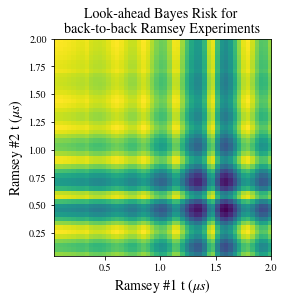

In [75]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, medium_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
lbr = lookahead_bayes_risk(updater, rabi_eps, rabi_eps)
fig = plt.figure()
plt.imshow(lbr, extent=[np.min(ramsey_eps['tau']),np.max(ramsey_eps['tau']),np.min(ramsey_eps['tau']),np.max(ramsey_eps['tau'])])
plt.title('Look-ahead Bayes Risk for \nback-to-back Ramsey Experiments')
plt.xlabel('Ramsey #1 t $(\mu s)$')
plt.ylabel('Ramsey #2 t $(\mu s)$')
export_figure(fig, 'risk-look-ahead')

In [ ]:
n_bin = 10
n_particles = 2000
n_experiments = 200
n_trials = 500

def make_updater():
    if not parallel:
        return qi.BinomialModel(m.RabiRamseyModel())
    else:
        return qi.DirectViewParallelizedModel(qi.BinomialModel(m.RabiRamseyModel()), dview, serial_threshold=1)

Q = np.array([1,1,0,0,0])
n_updaters=3

heuristics_hal = []

track_means_lah = np.zeros((n_trials, n_updaters, n_experiments + 1, 5))
track_covs_lah = np.zeros((n_trials, n_updaters, n_experiments + 1, 5, 5))

for idx_trial in range(n_trials):
    print "Starting Trial {}".format(idx_trial)
    print "================="
    
    heuristics_hal.append([])
    heuristics_hal[-1] = [
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Alternating    '
        ),
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Old Information'
        ),
        LookAheadRiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Look-Ahead     '
        ),
    ]
    
    for idx_h, h in enumerate(heuristics_hal[-1]):
        track_means_lah[idx_trial,idx_h, 0, :] = h.updater.est_mean()
        track_covs_lah[idx_trial,idx_h, 0, :, :] = h.updater.est_covariance_mtx()
        
    # heuristics 1 and 2 require an initial experiment to run
    eps0 = None
    current_est = heuristics_hal[-1][1].updater.est_mean()
    tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
    eps1 = heuristics_hal[-1][1](tp_est)
    eps2 = eps1

    for idx_eps in range(n_experiments):

        #--------------------------------------------------------------------
        # Alternating Heuristic: alternate experiments with risk optimization
        
        idx = 0
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        #estimate ramsey pulse time
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        #decide experiment
        eps0 = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps0[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # simulate outcome
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps0)
        # update
        updater.update(outcome, eps0)
        
        #--------------------------------------------------------------------
        # Old Info Heuristic:    compute risk concurrently, but on the old 
        #                        posterior
        
        idx = 1
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        # simulate outcome _before_ knowing best thing to do
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps1)
        # "simultaneously" decide next experiment based on old distribution
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        eps1_new = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps1_new[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # now both the experiment and the simulation are done, do the update
        updater.update(outcome, eps1)
        eps1 = eps1_new
        
        #--------------------------------------------------------------------
        # Look-Ahead Heuristic:  Take into account what we expect from the 
        #                        currently running experiment
        
        idx = 2
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        # simulate outcome _before_ knowing best thing to do
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps2)
        # "simultaneously" decide next experiment based on old distribution and currently running experiment
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        eps2_new = heuristic(eps2, tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps2_new[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # now both the experiment and the simulation are done, do the update
        updater.update(outcome, eps2)
        eps2 = eps2_new
        
        # store info
        for idx_h, h in enumerate(heuristics_hal[-1]):
            track_means_lah[idx_trial,idx_h, idx_eps, :] = h.updater.est_mean()
            track_covs_lah[idx_trial,idx_h, idx_eps, :, :] = h.updater.est_covariance_mtx()
        
        print "---"

Overwriting ../fig/qhl-lah-we-variance.png
Overwriting ../fig/qhl-lah-we-variance.pdf


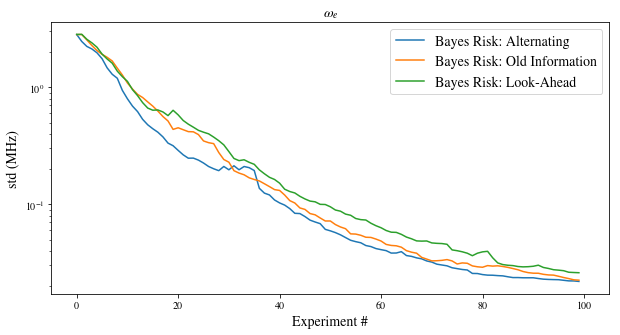

In [112]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(len(heuristics_hal[0])):
    h = heuristics_hal[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs_lah[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-lah-we-variance')